<a href="https://www.kaggle.com/code/mstasyuk/simpsons-classification?scriptVersionId=132849105" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Loading Data, Imports

In [1]:
!pip install mlflow --quiet
!pip install pyngrok --quiet

In [ ]:
%%capture
%%bash
# wget "https://www.dropbox.com/s/a08z03ih16eoiwv/mlflow.db?dl=0" -O mlflow.db
# wget "https://www.dropbox.com/s/wfi55wumsubjjb6/mlruns.zip?dl=0" -O mlruns.zip
unzip mlruns.zip -d /

In [2]:
%%capture
%%bash
wget "https://www.dropbox.com/s/2sxx1f5x4f353tq/journey-springfield-augmented.zip?dl=0" -O journey-springfield.zip

mkdir data



In [ ]:
%%capture
!unzip journey-springfield.zip -d ./data

In [3]:
%%bash
mv ./data/journey-springfield/testset ./data/test
mv ./data/journey-springfield/train/simpsons_dataset ./data/
rmdir ./data/journey-springfield/train
mv ./data/simpsons_dataset ./data/train
rm -r data/journey-springfield

In [4]:
# Check if data exists
![ -d "./data/train" ] && echo "Directory ./data/train exists."
![ -d "./data/test" ] && echo "Directory ./data/testset exists."
![ -d "./mlruns" ] && echo "Directory ./mlruns exists."
![ -f "./mlflow.db" ] && echo "mlflow.db exists."

Directory ./data/train exists.
Directory ./data/testset exists.


In [5]:
from __future__ import print_function, division
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, Subset, DataLoader
from torchvision import transforms, datasets, models

import matplotlib.pyplot as plt

import mlflow

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
import torchmetrics
import time
import os
import copy
import pickle

from sklearn.model_selection import train_test_split

cudnn.benchmark = True

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [6]:
# Choose processor
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [7]:
# Define simple transforms
augmentations = [
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.5, 1.5)),
    transforms.RandomHorizontalFlip(),
]
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomChoice(augmentations),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [8]:
data_dir = './data/'

In [9]:
# Create image datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) \
                  for x in ['train', 'test']}

In [10]:
# Split train data to train and val subsets

VAL_SIZE = 0.2
train_idx, validation_idx = train_test_split(np.arange(len(image_datasets['train'])),
                                             test_size=VAL_SIZE,
                                             random_state=1,
                                             shuffle=True,
                                             stratify=image_datasets['train'].targets)

train_set = Subset(image_datasets['train'], train_idx)
val_set = Subset(image_datasets['train'], validation_idx)

print("Train size: {}, validation size: {}".format(len(train_set), len(val_set)))
dsets = {'train': train_set, 'val': val_set}

dataset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}

Train size: 50996, validation size: 12749


In [11]:
# Create loaders

train_loader = DataLoader(dsets['train'], batch_size=32,
                                             shuffle=True, num_workers=2)
val_loader = DataLoader(dsets['val'], batch_size=64,
                                             shuffle=False, num_workers=2)

test_loader = DataLoader(image_datasets['test'], batch_size=64,
                                             shuffle=False, num_workers=2)

dataloaders = {'train':train_loader, 'val': val_loader, 'test': test_loader}

class_names = image_datasets['train'].classes

In [12]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.set_title(title)

    return ax

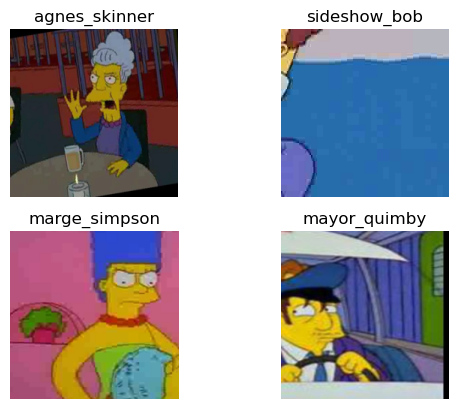

In [13]:
# Run this to test your data loader
images, labels = next(iter(dataloaders['train']))
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2)
imshow(images[0], ax=ax0, normalize=True, title=image_datasets['train'].classes[labels[0]])
imshow(images[1], ax=ax1, normalize=True, title=image_datasets['train'].classes[labels[1]])
imshow(images[2], ax=ax2, normalize=True, title=image_datasets['train'].classes[labels[2]])
imshow(images[3], ax=ax3, normalize=True, title=image_datasets['train'].classes[labels[3]]);

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    param_model_name = str(model_ft.__class__).replace('.', '-')[8:-2]
    with mlflow.start_run(run_name=param_model_name):
        mlflow.log_param('optimizer', param_optimizer)
        mlflow.log_param('lr', param_lr)
#         mlflow.log_param('batch_size', param_bs)
        mlflow.log_param('val_size', VAL_SIZE)
        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0
                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                if phase == 'train':
                    scheduler.step()
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
                mlflow.log_metric(f'{phase}_epoch_loss', epoch_loss)
                mlflow.log_metric(f'{phase}_epoch_accuracy', epoch_acc)

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    mlflow.pytorch.log_model(model_ft, artifact_path='models')

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        mlflow.log_metric('best_accuracy', best_acc)
        
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [15]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1

                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
    
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j], ax=ax, title=class_names[preds[j]])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

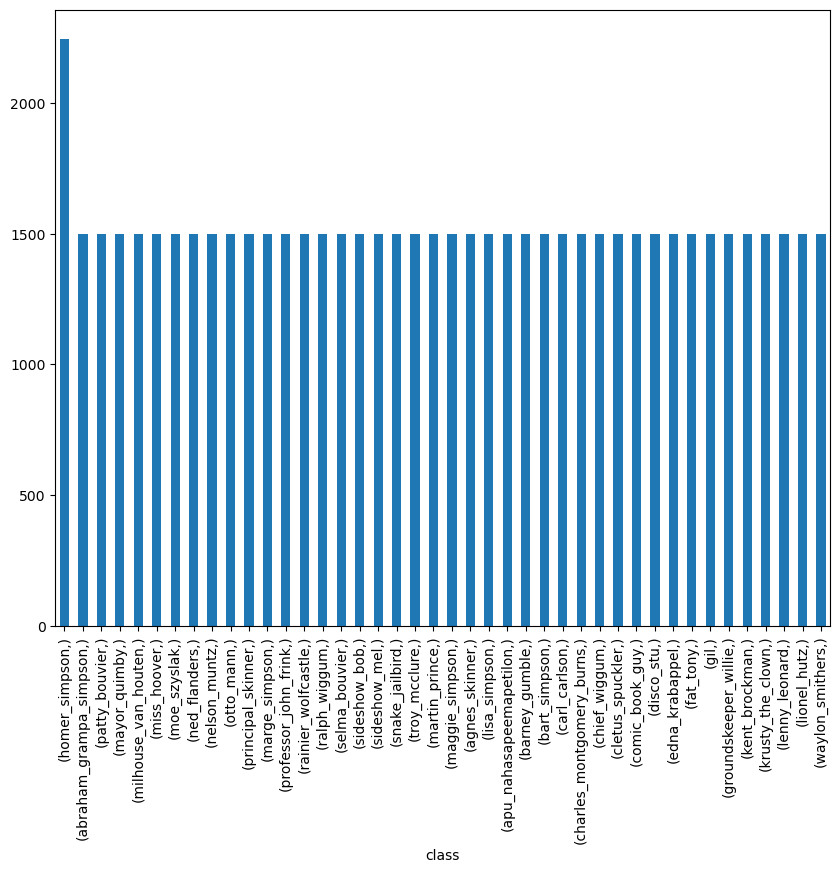

In [16]:
classes = pd.DataFrame(image_datasets['train'].targets, columns=['class']).applymap(lambda x: class_names[x])
plt.figure(figsize=(10,8))
classes.value_counts().plot(kind='bar')

plt.show()

In [18]:
!pip install lion_pytorch --quiet
from lion_pytorch import Lion

In [36]:
LR = 1e-4

model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# # Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=LR) # Adam
# optimizer_ft = Lion(model_ft.parameters(), lr=LR, weight_decay=1e-2) # Lion

# # Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 152MB/s] 


In [37]:
# Hyperparameters to log
param_optimizer = str(optimizer_ft.__class__)[8:-2]
param_lr = optimizer_ft.state_dict()['param_groups'][0]['initial_lr']

In [29]:
def run_mlflow():
    # run tracking UI in the background
    get_ipython().system_raw("mlflow ui --port 5000 --backend-store-uri sqlite:///mlflow.db &") # run tracking UI in the background

    ### run here

    # create remote tunnel using ngrok.com to allow local port access
    # borrowed from https://colab.research.google.com/github/alfozan/MLflow-GBRT-demo/blob/master/MLflow-GBRT-demo.ipynb#scrollTo=4h3bKHMYUIG6

    from pyngrok import ngrok
    # Terminate open tunnels if exist
    ngrok.kill()

    # Setting the authtoken (optional)
    # Get your authtoken from https://dashboard.ngrok.com/auth
    NGROK_AUTH_TOKEN = "2QbvkNkFfJgD1wDiD1gASh53VKq_7PNxKw7RQtSf44Sk6pGUX"
    ngrok.set_auth_token(NGROK_AUTH_TOKEN)

    # Open an HTTPs tunnel on port 5000 for http://localhost:5000
    ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
    print("MLflow Tracking UI:", ngrok_tunnel.public_url)

In [40]:
run_mlflow()

WARNI [pyngrok.process.ngrok] t=2023-06-08T17:02:34+0000 lvl=warn msg="ngrok config file found at legacy location, move to XDG location" xdg_path=/root/.config/ngrok/ngrok.yml legacy_path=/root/.ngrok2/ngrok.yml


MLflow Tracking UI: https://f497-34-147-29-214.ngrok-free.app


In [42]:
mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('resnet18-adam-balanced-augmented')

<Experiment: artifact_location='/kaggle/working/mlruns/2', creation_time=1686243729114, experiment_id='2', last_update_time=1686243729114, lifecycle_stage='active', name='resnet18-adam-balanced-augmented', tags={}>

In [43]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                          num_epochs=25)

Epoch 0/24
----------


2023/06/08 17:02:49 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/06/08 17:02:49 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2023/06/08 17:02:52 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/06/08 17:02:52 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2023/06/08 17:02:52 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/06/08 17:02:52 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional D

train Loss: 0.2834 Acc: 0.9464
val Loss: 0.0951 Acc: 0.9775
Epoch 1/24
----------
train Loss: 0.0779 Acc: 0.9823
val Loss: 0.0844 Acc: 0.9781
Epoch 2/24
----------
train Loss: 0.0554 Acc: 0.9864
val Loss: 0.0666 Acc: 0.9833
Epoch 3/24
----------
train Loss: 0.0247 Acc: 0.9945
val Loss: 0.0341 Acc: 0.9922
Epoch 4/24
----------
train Loss: 0.0165 Acc: 0.9965
val Loss: 0.0303 Acc: 0.9923
Epoch 5/24
----------
train Loss: 0.0130 Acc: 0.9973
val Loss: 0.0279 Acc: 0.9930
Epoch 6/24
----------
train Loss: 0.0095 Acc: 0.9980
val Loss: 0.0265 Acc: 0.9934
Epoch 7/24
----------


2023/06/08 17:27:18 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/06/08 17:27:18 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2023/06/08 17:27:20 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/06/08 17:27:20 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


train Loss: 0.0094 Acc: 0.9983
val Loss: 0.0271 Acc: 0.9932
Epoch 8/24
----------
train Loss: 0.0088 Acc: 0.9981
val Loss: 0.0281 Acc: 0.9935
Epoch 9/24
----------


2023/06/08 17:34:19 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/06/08 17:34:19 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2023/06/08 17:35:19 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/06/08 17:35:19 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


train Loss: 0.0095 Acc: 0.9980
val Loss: 0.0268 Acc: 0.9934
Epoch 10/24
----------
train Loss: 0.0096 Acc: 0.9982
val Loss: 0.0262 Acc: 0.9940
Epoch 11/24
----------
train Loss: 0.0082 Acc: 0.9984
val Loss: 0.0281 Acc: 0.9926
Epoch 12/24
----------
train Loss: 0.0081 Acc: 0.9986
val Loss: 0.0249 Acc: 0.9935
Epoch 13/24
----------
train Loss: 0.0083 Acc: 0.9983
val Loss: 0.0281 Acc: 0.9936
Epoch 14/24
----------
train Loss: 0.0078 Acc: 0.9987
val Loss: 0.0252 Acc: 0.9937
Epoch 15/24
----------
train Loss: 0.0081 Acc: 0.9986
val Loss: 0.0279 Acc: 0.9932
Epoch 16/24
----------
train Loss: 0.0086 Acc: 0.9983
val Loss: 0.0276 Acc: 0.9930
Epoch 17/24
----------
train Loss: 0.0081 Acc: 0.9987
val Loss: 0.0318 Acc: 0.9921
Epoch 18/24
----------
train Loss: 0.0078 Acc: 0.9986
val Loss: 0.0256 Acc: 0.9933
Epoch 19/24
----------
train Loss: 0.0079 Acc: 0.9984
val Loss: 0.0268 Acc: 0.9932
Epoch 20/24
----------
train Loss: 0.0088 Acc: 0.9983
val Loss: 0.0266 Acc: 0.9932
Epoch 21/24
----------
trai

In [44]:
def compute_f1(model, loader):
    was_training = model.training
    model.eval()
    f1_hist = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            f1 = torchmetrics.functional.f1_score(preds, labels, task="multiclass", num_classes=len(class_names))
            f1_hist.append(f1.cpu())
    model.train(mode=was_training)
    return np.mean(f1_hist)

In [45]:
# Use trained model to make predictions and compute f1 score
model_path = '/kaggle/working/mlruns/2/da8e8c89e52146b48d4820dd08b0428a/artifacts/models/data/model.pth'

model_trained = torch.load(model_path)
avg_f1 = compute_f1(model_trained, dataloaders['train'])
print('Train f1:', avg_f1)
avg_f1 = compute_f1(model_trained, dataloaders['val'])
print('Validation f1:', avg_f1)

Train f1: 0.99892175
Validation f1: 0.9932031


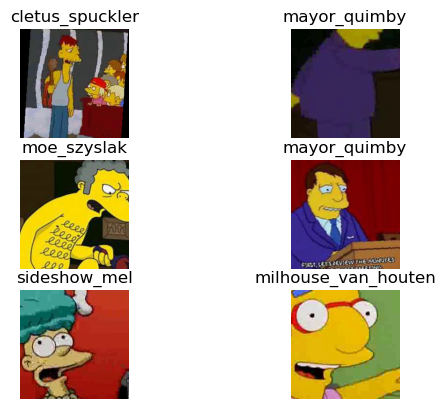

In [49]:
visualize_model(model_trained, num_images=6)

In [51]:
# Predict classes on test data

def predict(model):
    was_training = model.training
    model.eval()
    predictions = np.empty((0, 1))
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            preds_array = preds.cpu().unsqueeze(1)
            predictions = np.vstack((predictions, preds_array))
    
    model.train(mode=was_training)
    return predictions
predictions = pd.Series(predict(model_trained).squeeze(), name='Expected').apply(lambda x: class_names[int(x)])
predictions.shape

(991,)

In [52]:
filenames = pd.Series([item[0].replace('./data/test/testset/', '') for item in image_datasets['test'].samples], name='Id')

submission_df = pd.concat((filenames, predictions), axis=1).set_index('Id')
submission_df

,Expected
Id,
img0.jpg,nelson_muntz
img1.jpg,bart_simpson
img10.jpg,ned_flanders
img100.jpg,chief_wiggum
img101.jpg,apu_nahasapeemapetilon
...,...
img987.jpg,nelson_muntz
img988.jpg,marge_simpson
img989.jpg,charles_montgomery_burns


In [53]:
submission_df.to_csv('submission.csv')

In [55]:
# Backup mlruns
!zip -r mlruns.zip /kaggle/working/mlruns

  adding: kaggle/working/mlruns/ (stored 0%)
  adding: kaggle/working/mlruns/2/ (stored 0%)
  adding: kaggle/working/mlruns/2/da8e8c89e52146b48d4820dd08b0428a/ (stored 0%)
  adding: kaggle/working/mlruns/2/da8e8c89e52146b48d4820dd08b0428a/artifacts/ (stored 0%)
  adding: kaggle/working/mlruns/2/da8e8c89e52146b48d4820dd08b0428a/artifacts/models/ (stored 0%)
  adding: kaggle/working/mlruns/2/da8e8c89e52146b48d4820dd08b0428a/artifacts/models/conda.yaml (deflated 37%)
  adding: kaggle/working/mlruns/2/da8e8c89e52146b48d4820dd08b0428a/artifacts/models/requirements.txt (deflated 26%)
  adding: kaggle/working/mlruns/2/da8e8c89e52146b48d4820dd08b0428a/artifacts/models/data/ (stored 0%)
  adding: kaggle/working/mlruns/2/da8e8c89e52146b48d4820dd08b0428a/artifacts/models/data/pickle_module_info.txt (stored 0%)
  adding: kaggle/working/mlruns/2/da8e8c89e52146b48d4820dd08b0428a/artifacts/models/data/model.pth (deflated 7%)
  adding: kaggle/working/mlruns/2/da8e8c89e52146b48d4820dd08b0428a/artifacts